In [3]:
import tensorflow as tf
import numpy as np

from models.Unet3D import unet_3d
import losses

In [4]:
CLASSES = 8
CHANNELS = 3
SIZE = 96

model = unet_3d(class_num = CLASSES, size = SIZE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 96, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 96, 96, 96, 32) │          2,624 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 96, 96, 96, 32) │            128 │ conv3d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 96, 96, 96, 32) │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_5… │
│                           │                        │                │ batch_normalization_6… │
│                           │                        │                │ batch_normalization_7… │
│                           │                        │                │ batch_normalization_8… │
│                           │                        │                │ batch_normalization_9… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 96, 96, 96, 32) │         27,680 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 96, 96, 96, 32) │            128 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 48, 48, 48, 64) │         55,360 │ leaky_re_lu[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 48, 48, 48, 64) │            256 │ conv3d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 48, 48, 48, 64) │        110,656 │ leaky_re_lu[2][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 26,338,952 (100.48 MB)

 Trainable params: 26,333,048 (100.45 MB)

 Non-trainable params: 5,904 (23.06 KB)

Create some dataset for testing

In [10]:
TRAIN_LENGTH = 10
TEST_LENGTH = 4
BATCH_SIZE = 2

MATRIX = np.random.choice(np.arange(10, dtype=np.float16), size=(CHANNELS, CLASSES), replace=True)

def normalize(data):
    return (data / 127.5) - 1.0

def get_dataset(data_size):
    features = []
    labels = []
    for i in range(data_size):
        data = np.random.choice(np.arange(256, dtype=np.float16), size=(SIZE, SIZE, SIZE, CHANNELS), replace=True)
        features.append(normalize(data))
    labels = np.dot(features, MATRIX)
    return tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(features, dtype=tf.float16), tf.convert_to_tensor(labels, dtype=tf.float16)))

train_dataset = get_dataset(TRAIN_LENGTH)
test_dataset = get_dataset(TEST_LENGTH)


In [11]:
train_batches = train_dataset.batch(BATCH_SIZE).repeat()
test_batches = test_dataset.batch(BATCH_SIZE).repeat()

In [12]:
model = unet_3d(class_num = CLASSES, size = SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=losses.dice_loss,
              metrics=['accuracy'])

model_history = model.fit(train_batches,
                          epochs=3,
                          steps_per_epoch=TRAIN_LENGTH // BATCH_SIZE,
                          validation_steps=TEST_LENGTH // BATCH_SIZE,
                          validation_data=test_batches)

Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.1236 - loss: 1.0219 - val_accuracy: 0.0847 - val_loss: 1.0003
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1278 - loss: 0.9587 - val_accuracy: 0.1299 - val_loss: 0.9966
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1321 - loss: 0.8965 - val_accuracy: 0.1542 - val_loss: 0.9925


In [13]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

print(loss)
print(val_loss)

[1.0097087621688843, 0.9475836753845215, 0.8860637545585632]
[1.0003005266189575, 0.996625542640686, 0.992473840713501]


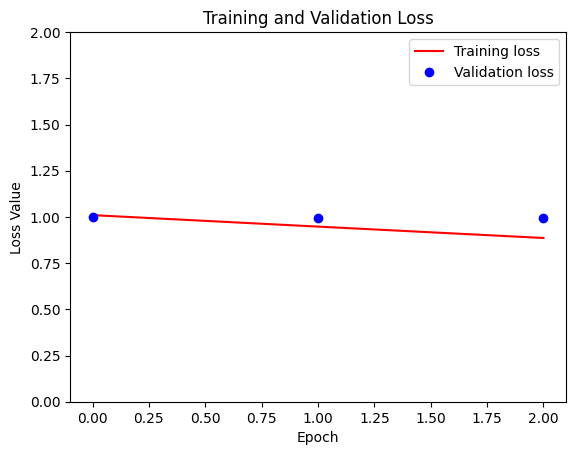

In [14]:
import matplotlib.pyplot as plt

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 2])
plt.legend()
plt.show()

In [16]:
# check losses are equal to tf implementation
for j, d in enumerate(test_dataset):
    img = tf.expand_dims(d[0], axis=0)
    label = tf.expand_dims(d[1], axis=0)

    prediction = model.predict(img)

    print(f'dice loss: {losses.dice_loss(label, prediction, 0)}')
    print(f'tf dice loss: {tf.keras.losses.Dice()(label, prediction)}')

    print(f'cross entropy: {losses.cross_entropy(label, prediction)}')
    print(f'tf cross entropy: {tf.keras.losses.CategoricalCrossentropy(from_logits=False)(label, prediction)}')
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
dice loss: 0.9867728352546692
tf dice loss: 0.9867728352546692
cross entropy: -0.01102085318416357
tf cross entropy: -0.011020861566066742
